In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration - use CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Disable multiprocessing in Kaggle
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

Using device: cuda


In [2]:
class PETClinicalDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        dicom_path, label, clinical_features = self.data_list[idx]
        
        try:
            # Load DICOM volume
            volume = self.load_dicom_volume(dicom_path)
            
            # Apply transforms if any
            if self.transform:
                volume = self.transform(volume)
                
            # Convert to tensor and add channel dimension
            volume = torch.from_numpy(volume).float()
            if volume.ndim == 3:
                volume = volume.unsqueeze(0)  # Add channel dimension
                
            # Convert clinical features to tensor
            clinical_features = torch.from_numpy(clinical_features).float()
            
            return volume, clinical_features, label
            
        except Exception as e:
            print(f"Error loading {dicom_path}: {str(e)}")
            # Return dummy data if loading fails
            dummy_volume = torch.zeros(1, 96, 96, 96)
            dummy_features = torch.zeros(2)
            return dummy_volume, dummy_features, 0
    
    def load_dicom_volume(self, dicom_dir):
        """Load a series of DICOM files into a 3D volume"""
        dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
        if not dicom_files:
            raise ValueError(f"No DICOM files found in {dicom_dir}")
            
        dicom_files.sort()
        slices = []
        
        for filename in dicom_files:
            filepath = os.path.join(dicom_dir, filename)
            try:
                dicom = pydicom.dcmread(filepath)
                if hasattr(dicom, 'pixel_array'):
                    slices.append(dicom)
            except:
                continue
                
        if not slices:
            raise ValueError(f"No valid DICOM slices found in {dicom_dir}")
        
        # Sort slices by Z-position
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        
        # Create 3D volume
        volume = np.stack([s.pixel_array for s in slices])
        volume = volume.astype(np.float32)
        
        # Handle NaN/infinite values
        volume = np.nan_to_num(volume)
        
        # Normalize to [0, 1]
        min_val = volume.min()
        max_val = volume.max()
        if max_val > min_val:
            volume = (volume - min_val) / (max_val - min_val)
        
        return volume  # Returns 3D array (D, H, W)

In [3]:
class RandomCrop3D:
    """Random 3D crop to target size with padding if needed"""
    def __init__(self, output_size):
        self.output_size = (output_size, output_size, output_size) if isinstance(output_size, int) else output_size
    
    def __call__(self, volume):
        # Ensure volume is 3D (D, H, W)
        if volume.ndim == 3:
            d, h, w = volume.shape
        else:
            raise ValueError(f"Expected 3D input, got {volume.ndim}D")
        
        # Pad if needed
        pad_d = max(self.output_size[0] - d, 0)
        pad_h = max(self.output_size[1] - h, 0)
        pad_w = max(self.output_size[2] - w, 0)
        
        if pad_d > 0 or pad_h > 0 or pad_w > 0:
            volume = np.pad(volume, 
                          ((pad_d//2, pad_d - pad_d//2),
                           (pad_h//2, pad_h - pad_h//2),
                           (pad_w//2, pad_w - pad_w//2)), 
                          mode='constant')
        
        # Random crop
        d, h, w = volume.shape
        new_d, new_h, new_w = self.output_size
        
        depth = np.random.randint(0, d - new_d) if d > new_d else 0
        top = np.random.randint(0, h - new_h) if h > new_h else 0
        left = np.random.randint(0, w - new_w) if w > new_w else 0
        
        volume = volume[depth:depth+new_d, top:top+new_h, left:left+new_w]
        
        return volume

class CenterCrop3D:
    """Center crop to target size with padding if needed"""
    def __init__(self, output_size):
        self.output_size = (output_size, output_size, output_size) if isinstance(output_size, int) else output_size
    
    def __call__(self, volume):
        # Ensure volume is 3D (D, H, W)
        if volume.ndim == 3:
            d, h, w = volume.shape
        else:
            raise ValueError(f"Expected 3D input, got {volume.ndim}D")
        
        # Pad if needed
        pad_d = max(self.output_size[0] - d, 0)
        pad_h = max(self.output_size[1] - h, 0)
        pad_w = max(self.output_size[2] - w, 0)
        
        if pad_d > 0 or pad_h > 0 or pad_w > 0:
            volume = np.pad(volume, 
                          ((pad_d//2, pad_d - pad_d//2),
                           (pad_h//2, pad_h - pad_h//2),
                           (pad_w//2, pad_w - pad_w//2)), 
                          mode='constant')
        
        # Center crop
        d, h, w = volume.shape
        new_d, new_h, new_w = self.output_size
        
        depth = (d - new_d) // 2
        top = (h - new_h) // 2
        left = (w - new_w) // 2
        
        volume = volume[depth:depth+new_d, top:top+new_h, left:left+new_w]
        
        return volume

In [4]:
class MultimodalAlzheimerClassifier(nn.Module):
    def __init__(self, num_clinical_features=2, num_classes=2):
        super().__init__()
        
        # Image pathway (3D CNN)
        self.image_features = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.AdaptiveAvgPool3d(1)
        )
        
        # Clinical data pathway
        self.clinical_net = nn.Sequential(
            nn.Linear(num_clinical_features, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 + 64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x_img, x_clinical):
        # Extract image features
        img_features = self.image_features(x_img)
        img_features = img_features.view(img_features.size(0), -1)
        
        # Process clinical data
        clinical_features = self.clinical_net(x_clinical)
        
        # Combine features
        combined = torch.cat([img_features, clinical_features], dim=1)
        
        # Final classification
        out = self.classifier(combined)
        
        return out

In [5]:
def load_metadata(csv_path):
    """Load and preprocess the CSV metadata"""
    df = pd.read_csv(csv_path)
    
    # Basic cleaning
    df = df.dropna(subset=['Subject', 'Group'])
    df['Group'] = df['Group'].str.strip().str.upper()
    
    # Create label mapping
    group_mapping = {
        'AD': 1,
        'CN': 0,
        'CONTROL': 0,
        'MCI': 1,
        'LMCI': 1,
        'EMCI': 1,
        'ADNI': 1
    }
    
    df['label'] = df['Group'].map(group_mapping)
    df = df.dropna(subset=['label'])  # Remove unmapped groups
    
    # Convert age to numeric
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # One-hot encode sex
    df['Sex_M'] = (df['Sex'] == 'M').astype(int)
    
    # Handle duplicate Subject IDs - keep first occurrence
    df = df.drop_duplicates(subset=['Subject'], keep='first')
    
    return df

def prepare_data_list_with_metadata(base_path, metadata_df):
    """Prepare list of (dicom_path, label, clinical_features) tuples"""
    data_list = []
    
    # Create lookup dictionary for metadata
    subject_metadata = metadata_df.set_index('Subject').to_dict('index')
    
    # Walk through directory structure
    for root, dirs, files in os.walk(base_path):
        # Look for directories containing DICOM files
        if any(f.endswith('.dcm') for f in files):
            # Get subject ID from directory structure
            parts = root.split(os.sep)
            subject_id = parts[-4]  # Adjust based on your structure
            
            # Only proceed if we have metadata for this subject
            if subject_id in subject_metadata:
                metadata = subject_metadata[subject_id]
                
                # Prepare clinical features vector
                clinical_features = np.array([
                    metadata['Age'],
                    metadata['Sex_M']
                ], dtype=np.float32)
                
                data_list.append((
                    root,  # DICOM directory path
                    int(metadata['label']),  # 0 or 1
                    clinical_features  # Additional clinical data
                ))
    
    return data_list

In [12]:
def train_multimodal_model(model, train_loader, val_loader, device, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.1)
    
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Disable tqdm for Kaggle compatibility
        for images, clinical, labels in train_loader:
            images = images.to(device)
            clinical = clinical.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images, clinical)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        val_loss, val_acc = evaluate_multimodal_model(model, val_loader, criterion, device)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Update scheduler
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_multimodal_model.pth')
        
        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    return history

def evaluate_multimodal_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, clinical, labels in data_loader:
            images = images.to(device)
            clinical = clinical.to(device)
            labels = labels.to(device)
            
            outputs = model(images, clinical)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = running_loss / len(data_loader.dataset)
    acc = correct / total
    
    return loss, acc

Loading metadata...
Preparing data list...

Starting training...


Epochs: 100%|██████████| 10/10 [41:54<00:00, 251.50s/epoch, train_loss=0.649, train_acc=0.629, val_loss=0.63, val_acc=0.686]



Test Accuracy: 0.6364

Classification Report:
              precision    recall  f1-score   support

          CN       0.44      0.85      0.58        13
          AD       0.89      0.55      0.68        31

    accuracy                           0.64        44
   macro avg       0.67      0.70      0.63        44
weighted avg       0.76      0.64      0.65        44



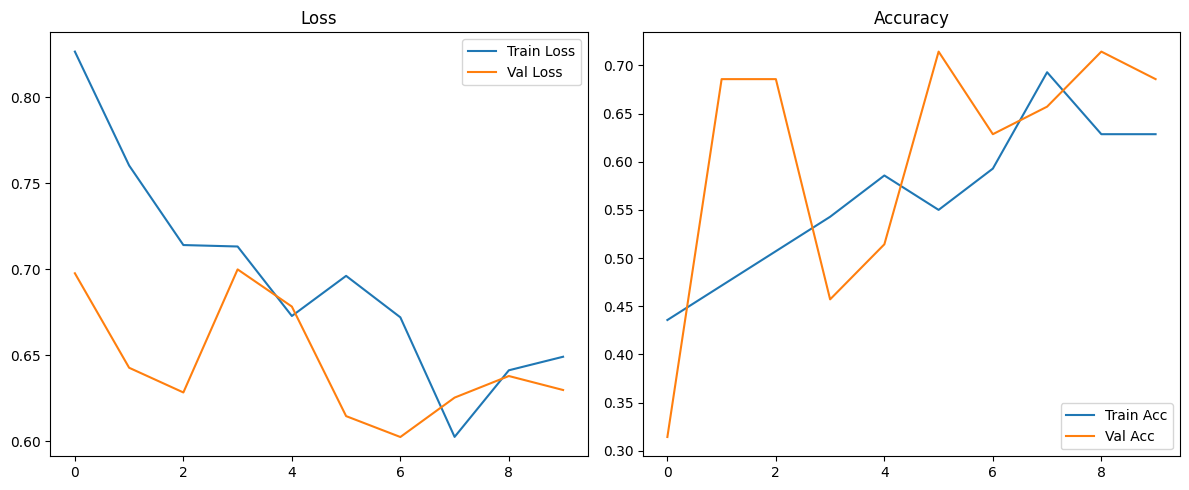

In [13]:
# Cell 7: Main Execution with tqdm Progress Bars
# Configuration
base_path = '/kaggle/input/pet-data/pet_same_patients_arc/ADNI'
metadata_path = '/kaggle/input/pet-csv-data/pet_same_patients_arc_8_01_2025.csv'
batch_size = 8
num_epochs = 10
input_size = 96

# Load and prepare data
print("Loading metadata...")
metadata_df = load_metadata(metadata_path)

print("Preparing data list...")
data_list = prepare_data_list_with_metadata(base_path, metadata_df)

# Check if we found any data
if not data_list:
    raise ValueError("No valid data found! Check your paths and metadata.")

# Split data
train_list, test_list = train_test_split(
    data_list, test_size=0.2, random_state=42, 
    stratify=[x[1] for x in data_list]
)
train_list, val_list = train_test_split(
    train_list, test_size=0.2, random_state=42, 
    stratify=[x[1] for x in train_list]
)

# Create datasets
train_transform = Compose([RandomCrop3D(input_size)])
val_transform = Compose([CenterCrop3D(input_size)])

train_dataset = PETClinicalDataset(train_list, transform=train_transform)
val_dataset = PETClinicalDataset(val_list, transform=val_transform)
test_dataset = PETClinicalDataset(test_list, transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Initialize model
num_clinical_features = train_dataset[0][1].shape[0]
model = MultimodalAlzheimerClassifier(num_clinical_features=num_clinical_features).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.1)
best_val_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("\nStarting training...")
epoch_pbar = tqdm(range(num_epochs), desc="Epochs", unit="epoch")

for epoch in epoch_pbar:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    batch_pbar = tqdm(train_loader, desc=f"Batches", leave=False)
    for images, clinical, labels in batch_pbar:
        images = images.to(device)
        clinical = clinical.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, clinical)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        batch_pbar.set_postfix({
            'batch_loss': loss.item(),
            'batch_acc': correct/total
        })
    
    batch_pbar.close()
    
    # Calculate metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    val_loss, val_acc = evaluate_multimodal_model(model, val_loader, criterion, device)
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Update scheduler and save best model
    scheduler.step(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_multimodal_model.pth')
    
    # Update epoch progress
    epoch_pbar.set_postfix({
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    })

epoch_pbar.close()

# Evaluation
model.load_state_dict(torch.load('best_multimodal_model.pth'))
test_loss, test_acc = evaluate_multimodal_model(model, test_loader, criterion, device)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification Report
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, clinical, labels in test_loader:
        images = images.to(device)
        clinical = clinical.to(device)
        outputs = model(images, clinical)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['CN', 'AD']))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

MULTICLASS...3d CNN

In [31]:
import os
import numpy as np
import pandas as pd
import pydicom
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Disable multiprocessing in Kaggle
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

Using device: cuda


In [32]:
class PETClinicalDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        dicom_path, label, clinical_features = self.data_list[idx]
        
        try:
            # Load DICOM volume
            volume = self.load_dicom_volume(dicom_path)
            
            # Apply transforms if any
            if self.transform:
                volume = self.transform(volume)
                
            # Convert to tensor and add channel dimension
            volume = torch.from_numpy(volume).float()
            if volume.ndim == 3:
                volume = volume.unsqueeze(0)  # Add channel dimension
                
            # Convert clinical features to tensor
            clinical_features = torch.from_numpy(clinical_features).float()
            
            return volume, clinical_features, label
            
        except Exception as e:
            print(f"Error loading {dicom_path}: {str(e)}")
            # Return dummy data if loading fails
            dummy_volume = torch.zeros(1, 96, 96, 96)
            dummy_features = torch.zeros(2)
            return dummy_volume, dummy_features, 0
    
    def load_dicom_volume(self, dicom_dir):
        """Load a series of DICOM files into a 3D volume"""
        dicom_files = [f for f in os.listdir(dicom_dir) if f.endswith('.dcm')]
        if not dicom_files:
            raise ValueError(f"No DICOM files found in {dicom_dir}")
            
        dicom_files.sort()
        slices = []
        
        for filename in dicom_files:
            filepath = os.path.join(dicom_dir, filename)
            try:
                dicom = pydicom.dcmread(filepath)
                if hasattr(dicom, 'pixel_array'):
                    slices.append(dicom)
            except:
                continue
                
        if not slices:
            raise ValueError(f"No valid DICOM slices found in {dicom_dir}")
        
        # Sort slices by Z-position
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        
        # Create 3D volume
        volume = np.stack([s.pixel_array for s in slices])
        volume = volume.astype(np.float32)
        
        # Handle NaN/infinite values
        volume = np.nan_to_num(volume)
        
        # Normalize to [0, 1]
        min_val = volume.min()
        max_val = volume.max()
        if max_val > min_val:
            volume = (volume - min_val) / (max_val - min_val)
        
        return volume  # Returns 3D array (D, H, W)

In [33]:
class RandomCrop3D:
    """Random 3D crop to target size with padding if needed"""
    def __init__(self, output_size):
        self.output_size = (output_size, output_size, output_size) if isinstance(output_size, int) else output_size
    
    def __call__(self, volume):
        # Ensure volume is 3D (D, H, W)
        if volume.ndim == 3:
            d, h, w = volume.shape
        else:
            raise ValueError(f"Expected 3D input, got {volume.ndim}D")
        
        # Pad if needed
        pad_d = max(self.output_size[0] - d, 0)
        pad_h = max(self.output_size[1] - h, 0)
        pad_w = max(self.output_size[2] - w, 0)
        
        if pad_d > 0 or pad_h > 0 or pad_w > 0:
            volume = np.pad(volume, 
                          ((pad_d//2, pad_d - pad_d//2),
                           (pad_h//2, pad_h - pad_h//2),
                           (pad_w//2, pad_w - pad_w//2)), 
                          mode='constant')
        
        # Random crop
        d, h, w = volume.shape
        new_d, new_h, new_w = self.output_size
        
        depth = np.random.randint(0, d - new_d) if d > new_d else 0
        top = np.random.randint(0, h - new_h) if h > new_h else 0
        left = np.random.randint(0, w - new_w) if w > new_w else 0
        
        volume = volume[depth:depth+new_d, top:top+new_h, left:left+new_w]
        
        return volume

class CenterCrop3D:
    """Center crop to target size with padding if needed"""
    def __init__(self, output_size):
        self.output_size = (output_size, output_size, output_size) if isinstance(output_size, int) else output_size
    
    def __call__(self, volume):
        # Ensure volume is 3D (D, H, W)
        if volume.ndim == 3:
            d, h, w = volume.shape
        else:
            raise ValueError(f"Expected 3D input, got {volume.ndim}D")
        
        # Pad if needed
        pad_d = max(self.output_size[0] - d, 0)
        pad_h = max(self.output_size[1] - h, 0)
        pad_w = max(self.output_size[2] - w, 0)
        
        if pad_d > 0 or pad_h > 0 or pad_w > 0:
            volume = np.pad(volume, 
                          ((pad_d//2, pad_d - pad_d//2),
                           (pad_h//2, pad_h - pad_h//2),
                           (pad_w//2, pad_w - pad_w//2)), 
                          mode='constant')
        
        # Center crop
        d, h, w = volume.shape
        new_d, new_h, new_w = self.output_size
        
        depth = (d - new_d) // 2
        top = (h - new_h) // 2
        left = (w - new_w) // 2
        
        volume = volume[depth:depth+new_d, top:top+new_h, left:left+new_w]
        
        return volume

In [34]:
class MultimodalAlzheimerClassifier(nn.Module):
    def __init__(self, num_clinical_features=2, num_classes=3):  # Changed to 3 classes
        super().__init__()
        
        # Image pathway (3D CNN)
        self.image_features = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d(2),
            
            nn.AdaptiveAvgPool3d(1)
        )
        
        # Clinical data pathway
        self.clinical_net = nn.Sequential(
            nn.Linear(num_clinical_features, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(256 + 64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(128, num_classes)  # Output for 3 classes
        )
    
    def forward(self, x_img, x_clinical):
        # Extract image features
        img_features = self.image_features(x_img)
        img_features = img_features.view(img_features.size(0), -1)
        
        # Process clinical data
        clinical_features = self.clinical_net(x_clinical)
        
        # Combine features
        combined = torch.cat([img_features, clinical_features], dim=1)
        
        # Final classification
        out = self.classifier(combined)
        
        return out

In [35]:
def load_metadata(csv_path):
    """Load and preprocess the CSV metadata"""
    df = pd.read_csv(csv_path)
    
    # Basic cleaning
    df = df.dropna(subset=['Subject', 'Group'])
    df['Group'] = df['Group'].str.strip().str.upper()
    
    # Create label mapping for 3 classes
    group_mapping = {
        'AD': 0,
        'CN': 1,
        'MCI': 2,
        'CONTROL': 1,  # Map CONTROL to CN
        'LMCI': 2,     # Map LMCI to MCI
        'EMCI': 2      # Map EMCI to MCI
    }
    
    df['label'] = df['Group'].map(group_mapping)
    df = df.dropna(subset=['label'])  # Remove unmapped groups
    
    # Convert age to numeric
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # One-hot encode sex
    df['Sex_M'] = (df['Sex'] == 'M').astype(int)
    
    # Handle duplicate Subject IDs - keep first occurrence
    df = df.drop_duplicates(subset=['Subject'], keep='first')
    
    return df

def prepare_data_list_with_metadata(base_path, metadata_df):
    """Prepare list of (dicom_path, label, clinical_features) tuples"""
    data_list = []
    
    # Create lookup dictionary for metadata
    subject_metadata = metadata_df.set_index('Subject').to_dict('index')
    
    # Walk through directory structure
    for root, dirs, files in os.walk(base_path):
        # Look for directories containing DICOM files
        if any(f.endswith('.dcm') for f in files):
            # Get subject ID from directory structure
            parts = root.split(os.sep)
            subject_id = parts[-4]  # Adjust based on your structure
            
            # Only proceed if we have metadata for this subject
            if subject_id in subject_metadata:
                metadata = subject_metadata[subject_id]
                
                # Prepare clinical features vector
                clinical_features = np.array([
                    metadata['Age'],
                    metadata['Sex_M']
                ], dtype=np.float32)
                
                data_list.append((
                    root,  # DICOM directory path
                    int(metadata['label']),  # 0, 1, or 2
                    clinical_features  # Additional clinical data
                ))
    
    return data_list

In [36]:
def train_multimodal_model(model, train_loader, val_loader, device, num_epochs=50):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.1)
    
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    # Initialize tqdm for epochs
    epoch_pbar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")
    
    for epoch in epoch_pbar:
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, clinical, labels in train_loader:
            images = images.to(device)
            clinical = clinical.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images, clinical)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        val_loss, val_acc = evaluate_multimodal_model(model, val_loader, criterion, device)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Update scheduler
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_multimodal_model.pth')
        
        # Update progress bar
        epoch_pbar.set_postfix({
            'train_loss': f"{train_loss:.4f}",
            'train_acc': f"{train_acc:.4f}",
            'val_acc': f"{val_acc:.4f}"
        })
    
    epoch_pbar.close()
    return history

def evaluate_multimodal_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, clinical, labels in data_loader:
            images = images.to(device)
            clinical = clinical.to(device)
            labels = labels.to(device)
            
            outputs = model(images, clinical)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    loss = running_loss / len(data_loader.dataset)
    acc = correct / total
    
    return loss, acc

In [25]:
pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.9 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.8 MB/s eta 0:00:000:00:0100:01
  Attempting uninst

In [37]:
# Final Optimized Implementation with Correct GradScaler

# Configuration
base_path = '/kaggle/input/pet-data/pet_same_patients_arc/ADNI'
metadata_path = '/kaggle/input/pet-csv-data/pet_same_patients_arc_8_01_2025.csv'
batch_size = 16  # Increased batch size for better GPU utilization
num_epochs = 20
input_size = 96  # Kept smaller for memory efficiency
mixed_precision = True  # Enable mixed precision training

# Load and prepare data
print("Loading metadata...")
metadata_df = load_metadata(metadata_path)

print("Preparing data list...")
data_list = prepare_data_list_with_metadata(base_path, metadata_df)

if not data_list:
    raise ValueError("No valid data found! Check your paths and metadata.")

# Split data
train_list, test_list = train_test_split(
    data_list, test_size=0.2, random_state=42, 
    stratify=[x[1] for x in data_list]
)
train_list, val_list = train_test_split(
    train_list, test_size=0.2, random_state=42, 
    stratify=[x[1] for x in train_list]
)

# Create datasets with optimized transforms
train_transform = Compose([
    RandomCrop3D(input_size),
    # Add other memory-efficient transforms if needed
])
val_transform = Compose([
    CenterCrop3D(input_size)
])

train_dataset = PETClinicalDataset(train_list, transform=train_transform)
val_dataset = PETClinicalDataset(val_list, transform=val_transform)
test_dataset = PETClinicalDataset(test_list, transform=val_transform)

# Create optimized dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=2, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)

# Initialize model
num_clinical_features = train_dataset[0][1].shape[0]
model = MultimodalAlzheimerClassifier(num_clinical_features=num_clinical_features).to(device)

# Enable hardware optimizations
torch.backends.cudnn.benchmark = True

# Corrected mixed precision training setup
scaler = torch.amp.GradScaler(device_type='cuda', enabled=mixed_precision)  # Fixed initialization

# Optimized training function
def train_multimodal_model_fast(model, train_loader, val_loader, device, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs
    )
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_acc = 0.0
    
    epoch_pbar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")
    
    for epoch in epoch_pbar:
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, clinical, labels in train_loader:
            # Async data transfer to GPU
            images = images.to(device, non_blocking=True)
            clinical = clinical.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)  # Faster gradient clearing
            
            # Mixed precision forward pass
            with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=mixed_precision):
                outputs = model(images, clinical)
                loss = criterion(outputs, labels)
            
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            # Update metrics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch metrics
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        val_loss, val_acc = evaluate_multimodal_model(model, val_loader, criterion, device)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_multimodal_model.pth')
        
        # Update progress bar
        epoch_pbar.set_postfix({
            'train_loss': f"{train_loss:.4f}",
            'val_acc': f"{val_acc:.4f}",
            'lr': f"{scheduler.get_last_lr()[0]:.2e}"
        })
    
    return history

# Optimized evaluation function
@torch.no_grad()
def evaluate_multimodal_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, clinical, labels in data_loader:
        images = images.to(device, non_blocking=True)
        clinical = clinical.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=mixed_precision):
            outputs = model(images, clinical)
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(data_loader.dataset), correct / total

# Train the model
print("\nStarting optimized training...")
history = train_multimodal_model_fast(model, train_loader, val_loader, device, num_epochs)

# Evaluation
model.load_state_dict(torch.load('best_multimodal_model.pth'))
test_loss, test_acc = evaluate_multimodal_model(model, test_loader, nn.CrossEntropyLoss(), device)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Classification Report
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, clinical, labels in test_loader:
        images = images.to(device)
        clinical = clinical.to(device)
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=mixed_precision):
            outputs = model(images, clinical)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['AD', 'CN', 'MCI']))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Loading metadata...
Preparing data list...


TypeError: GradScaler.__init__() got an unexpected keyword argument 'device_type'

SWINIR arch

VIsualization

Patient ID: 002_S_0295
Modality: PT
Study Description: PET BRAIN METABOLIC
Image shape: (128, 128)


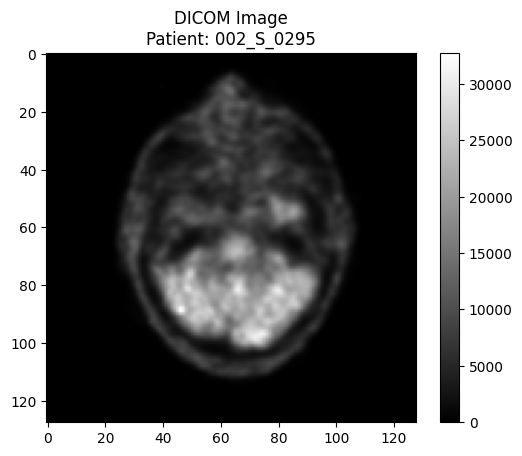

In [13]:
import pydicom
import matplotlib.pyplot as plt
import os
import glob

def visualize_dcm_file(dcm_path):
    """Visualize a single DICOM file"""
    ds = pydicom.dcmread(dcm_path)
    
    print(f"Patient ID: {ds.get('PatientID', 'N/A')}")
    print(f"Modality: {ds.get('Modality', 'N/A')}")
    print(f"Study Description: {ds.get('StudyDescription', 'N/A')}")
    print(f"Image shape: {ds.pixel_array.shape}")
    
    plt.imshow(ds.pixel_array, cmap='gray')
    plt.title(f"DICOM Image\nPatient: {ds.get('PatientID', 'N/A')}")
    plt.colorbar()
    plt.show()

# Example usage - find any DICOM file in your directory
sample_path = "/kaggle/input/pet-data/pet_same_patients_arc/ADNI/002_S_0295/Co-registered_Dynamic/2011-06-09_08_23_48.0/I240528/ADNI_002_S_0295_PT_Co-registered_Dynamic_Br_20110616150158579_199_S111104_I240528.dcm"

if os.path.exists(sample_path):
    visualize_dcm_file(sample_path)
else:
    print("Sample path not found, searching for any DICOM file...")
    # Search for any DICOM file recursively
    found_files = glob.glob('/kaggle/input/pet-data/**/*.dcm', recursive=True)
    if found_files:
        visualize_dcm_file(found_files[0])
    else:
        print("Could not find any DICOM files in the specified directory")

In [15]:
import os
import pydicom
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm import tqdm
from timm.models.swin_transformer import swin_base_patch4_window7_224

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [27]:
import pydicom
import pandas as pd
import numpy as np
import os
import glob
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class SimplePETDataset(Dataset):
    def __init__(self, root_dir, metadata_csv, transform=None, mode='binary'):
        """
        Simplified version that doesn't use XML metadata
        Args:
            root_dir (str): Root directory containing pet_same_patients_arc
            metadata_csv (str): Path to the CSV file with patient information
            transform (callable, optional): Optional transform to be applied
            mode (str): 'binary' for AD vs CN or 'multiclass' for AD vs CN vs MCI
        """
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        
        # Load metadata CSV
        self.metadata_df = pd.read_csv(metadata_csv)
        
        # Filter only PET images
        self.metadata_df = self.metadata_df[self.metadata_df['Modality'] == 'PET']
        
        # Filter based on classification mode
        if mode == 'binary':
            self.metadata_df = self.metadata_df[self.metadata_df['Group'].isin(['AD', 'CN'])]
        elif mode == 'multiclass':
            self.metadata_df = self.metadata_df[self.metadata_df['Group'].isin(['AD', 'CN', 'MCI'])]
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(self.metadata_df['Group'])
        
        # Create image paths by searching for DICOM files with matching Image Data ID
        self.image_paths = []
        self.valid_indices = []
        
        for idx, row in self.metadata_df.iterrows():
            image_id = row['Image Data ID']
            # Search for DICOM file with this ID in the filename
            search_pattern = os.path.join(root_dir, '**', f'*{image_id}.dcm')
            matches = glob.glob(search_pattern, recursive=True)
            
            if matches:
                self.image_paths.append(matches[0])
                self.valid_indices.append(idx)
            else:
                print(f"Warning: Could not find DICOM file for image ID {image_id}")
        
        # Filter metadata to only include found images
        self.metadata_df = self.metadata_df.iloc[self.valid_indices]
        self.labels = self.labels[self.valid_indices]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load DICOM image
        dicom_path = self.image_paths[idx]
        dicom = pydicom.dcmread(dicom_path)
        image = dicom.pixel_array
        
        # Normalize and convert to 3-channel (SwinIR expects RGB)
        image = image.astype(np.float32)
        image = (image - image.min()) / (image.max() - image.min())
        image = np.stack([image]*3, axis=0)  # Convert to 3-channel
        
        # Get label
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
    def get_label_mapping(self):
        return {i: label for i, label in enumerate(self.label_encoder.classes_)}

In [28]:
# Define transformations
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [29]:
class SwinIRForClassification(nn.Module):
    def __init__(self, num_classes, pretrained=True, label_encoder_classes=None, input_size=224):
        super(SwinIRForClassification, self).__init__()
        # Store additional info
        self.num_classes = num_classes
        self.label_encoder_classes = label_encoder_classes
        self.input_size = input_size
        
        # Load pretrained SwinIR model
        self.backbone = swin_base_patch4_window7_224(pretrained=pretrained)
        
        # Replace the head with our custom classifier
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)
    
    @classmethod
    def load_from_checkpoint(cls, checkpoint_path, device='cuda'):
        """Load model from checkpoint with proper error handling"""
        if not os.path.exists(checkpoint_path):
            raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")
        
        try:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model = cls(
                num_classes=checkpoint['num_classes'],
                label_encoder_classes=checkpoint['label_encoder_classes'],
                input_size=checkpoint['input_size']
            )
            model.load_state_dict(checkpoint['model_state_dict'])
            model = model.to(device)
            return model
        except Exception as e:
            raise RuntimeError(f"Error loading model from {checkpoint_path}: {str(e)}")

In [30]:
from tqdm.auto import tqdm  # For notebook-friendly progress bars
import time

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Initialize tqdm for epochs
    epoch_pbar = tqdm(range(num_epochs), desc='Total Training Progress', position=0)
    
    for epoch in epoch_pbar:
        # Update epoch description
        epoch_pbar.set_description(f'Epoch {epoch}/{num_epochs - 1}')
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                # Initialize tqdm for training batches
                batch_pbar = tqdm(dataloaders[phase], 
                                 desc=f'Training (Epoch {epoch})', 
                                 leave=False,
                                 position=1)
            else:
                model.eval()   # Set model to evaluate mode
                # Initialize tqdm for validation batches
                batch_pbar = tqdm(dataloaders[phase], 
                                 desc=f'Validation (Epoch {epoch})', 
                                 leave=False,
                                 position=1)
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data with progress bar
            for inputs, labels in batch_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update batch progress bar
                batch_pbar.set_postfix({
                    'loss': loss.item(),
                    'acc': torch.sum(preds == labels.data).item() / inputs.size(0)
                })
            
            # Close batch progress bar
            batch_pbar.close()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            # Update epoch progress bar
            epoch_pbar.set_postfix({
                f'{phase}_loss': f'{epoch_loss:.4f}',
                f'{phase}_acc': f'{epoch_acc:.4f}'
            })
            
            # Deep copy the model if it's the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Update progress bar to indicate best model
                epoch_pbar.set_postfix({
                    f'{phase}_loss': f'{epoch_loss:.4f}',
                    f'{phase}_acc': f'{epoch_acc:.4f} (best)'
                })
        
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def save_model(model, filepath, label_encoder_classes=None, input_size=224):
    """Save model with additional metadata"""
    torch.save({
        'model_state_dict': model.state_dict(),
        'label_encoder_classes': label_encoder_classes,
        'input_size': input_size,
        'num_classes': model.num_classes
    }, filepath)
    print(f"Model saved successfully to {filepath}")

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda'):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Initialize tqdm for epochs
    epoch_pbar = tqdm(range(num_epochs), desc='Total Training Progress', position=0)
    
    for epoch in epoch_pbar:
        # Update epoch description
        epoch_pbar.set_description(f'Epoch {epoch}/{num_epochs - 1}')
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                batch_pbar = tqdm(dataloaders[phase], 
                                 desc=f'Training (Epoch {epoch})', 
                                 leave=False,
                                 position=1)
            else:
                model.eval()
                batch_pbar = tqdm(dataloaders[phase], 
                                 desc=f'Validation (Epoch {epoch})', 
                                 leave=False,
                                 position=1)
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in batch_pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                batch_pbar.set_postfix({
                    'loss': loss.item(),
                    'acc': torch.sum(preds == labels.data).item() / inputs.size(0)
                })
            
            batch_pbar.close()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_pbar.set_postfix({
                f'{phase}_loss': f'{epoch_loss:.4f}',
                f'{phase}_acc': f'{epoch_acc:.4f}'
            })
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                epoch_pbar.set_postfix({
                    f'{phase}_loss': f'{epoch_loss:.4f}',
                    f'{phase}_acc': f'{epoch_acc:.4f} (best)'
                })
        
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    model.load_state_dict(best_model_wts)
    return model

def main():
    # Parameters
    data_root = '/kaggle/input/pet-data/pet_same_patients_arc/ADNI'
    metadata_csv = '/kaggle/input/pet-csv-data/pet_same_patients_arc_8_01_2025.csv'
    batch_size = 16
    num_epochs = 30
    learning_rate = 1e-4
    mode = 'binary'  # or 'multiclass'
    
    # Initialize dataset
    print("Loading dataset...")
    with tqdm(total=1, desc='Dataset Initialization') as pbar:
        full_dataset = SimplePETDataset(root_dir=data_root, 
                                     metadata_csv=metadata_csv, 
                                     transform=None,
                                     mode=mode)
        pbar.update(1)
    
    if len(full_dataset) == 0:
        print("Error: No DICOM files found. Please check your paths.")
        return
    
    # Visualize samples
    print("\nVisualizing samples...")
    for i in tqdm(range(min(3, len(full_dataset))), desc='Sample Visualization'):
        image, label = full_dataset[i]
        label_str = full_dataset.label_encoder.inverse_transform([label])[0]
        
        plt.figure(figsize=(8, 6))
        plt.imshow(image[0], cmap='gray')
        plt.title(f"Sample {i+1} - Label: {label_str}")
        plt.colorbar()
        plt.show()
    
    # Training setup
    print("\nSetting up training...")
    with tqdm(total=4, desc='Training Setup') as pbar:
        train_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        pbar.update(1)
        
        val_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        pbar.update(1)
        
        full_dataset.transform = train_transform
        
        train_idx, val_idx = train_test_split(
            range(len(full_dataset)), 
            test_size=0.2, 
            stratify=full_dataset.labels,
            random_state=42
        )
        pbar.update(1)
        
        train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
        val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
        val_dataset.dataset.transform = val_transform
        
        dataloaders = {
            'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
            'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
        }
        pbar.update(1)
    
    print(f"\nFound {len(train_dataset)} training samples and {len(val_dataset)} validation samples")
    print("Label distribution:", full_dataset.get_label_mapping())
    
    # Initialize model
    print("\nInitializing model...")
    with tqdm(total=1, desc='Model Setup') as pbar:
        num_classes = 2 if mode == 'binary' else 3
        model = SwinIRForClassification(num_classes=num_classes)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        pbar.update(1)
    
    # Store label encoder classes in the model
    model.label_encoder_classes = full_dataset.label_encoder.classes_
    model.input_size = 224
    model.num_classes = num_classes
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train the model
    print("\nStarting training...")
    model = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs, device=device)
    
    # Save the model with metadata
    save_model(model, f'swinir_pet_{mode}_classification.pth', 
              label_encoder_classes=full_dataset.label_encoder.classes_)
    print("\nTraining completed and model saved!")

if __name__ == '__main__':
    main()

Loading dataset...


Dataset Initialization:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
def load_model(filepath, device='cuda'):
    """Load a saved model with proper error handling"""
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"Model file not found at {filepath}")
    
    try:
        checkpoint = torch.load(filepath, map_location=device)
        model = SwinIRForClassification(
            num_classes=checkpoint['num_classes'],
            label_encoder_classes=checkpoint['label_encoder_classes'],
            input_size=checkpoint['input_size']
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model = model.to(device)
        return model
    except Exception as e:
        raise RuntimeError(f"Error loading model: {str(e)}")

# Example usage:
try:
    trained_model = load_model('swinir_pet_binary_classification.pth')
    result = predict_single_image(
        trained_model, 
        '/kaggle/input/pet-data/pet_same_patients_arc/ADNI/002_S_0295/Co-registered_Dynamic/2011-06-09_08_23_48.0/I240528/ADNI_002_S_0295_PT_Co-registered_Dynamic_Br_20110616150158579_199_S111104_I240528.dcm', 
        val_transform,  # Make sure to define your val_transform
        device=device
    )
    print(f"Prediction: {result['class_name']}")
    print(f"Probabilities: {result['probabilities']}")
except Exception as e:
    print(f"Error: {str(e)}")

NameError: name 'model' is not defined